# Create Torch image dataset

In [196]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image
import os
import gc

In [140]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torch.utils.data import DataLoader

## Prepare labels dataset

In [211]:
links = pd.read_pickle('../../data/1_automarket_exploration/source_data/total_frame_valid_links_2020-01-23 11:07.pckl')
labels = links[links['valid_img_count'] != 0]\
        [['producer', 'case', 'price', 'total_img_count']].reset_index()\
                                                          .rename(columns={'index':'dir_num'})
dicts = {}
for col in ['producer', 'case']:
    labels[col]  = labels[col].astype('category')
    labels[f'{col}_code'] = labels[col].cat.codes
    dicts[col] = dict(zip(labels[col].cat.codes, labels[col]))
    
labels['path'] = [f'img/{idx}/0.webp' for idx in labels['dir_num']]

#labels.to_pickle('../../data/1_automarket_exploration/source_data/labels.pckl')

In [149]:
labels.head()

,dir_num,producer,case,price,total_img_count,path,producer_code,case_code
0,0,BMW,хэтчбек 3 дв.,850000,4,img/0/0.webp,0,18
1,1,BMW,хэтчбек 3 дв.,707000,5,img/1/0.webp,0,18
2,2,BMW,хэтчбек 5 дв.,515000,3,img/2/0.webp,0,19
3,3,BMW,хэтчбек 5 дв.,709000,5,img/3/0.webp,0,19
4,4,BMW,хэтчбек 3 дв.,480000,5,img/4/0.webp,0,18


## Check shapes and clean image datatset

In [203]:
%%time
shapes = {}
errors = []
for idx, row in labels[['dir_num','path']].iterrows():
    try:
        img = Image.open(os.path.join('../../data/1_automarket_exploration/auto_img/', row['path']))
        shapes[row['dir_num']] = np.array(img).shape
        
    except Exception as e:
        errors.append(row['dir_num'])
        print(row['dir_num'], e)

3664 cannot identify image file '../../data/1_automarket_exploration/auto_img/img/3664/0.webp'
CPU times: user 6min 8s, sys: 39.5 s, total: 6min 47s
Wall time: 12min 31s


In [214]:
labels['shape'] = labels['dir_num'].map(shapes)
labels = labels[~labels['dir_num'].isin(errors)]
labels =  labels[labels['shape'] == (240, 320, 3)]

In [222]:
#labels.to_pickle('../../data/1_automarket_exploration/source_data/labels.pckl')

In [223]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235009 entries, 0 to 235215
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   dir_num          235009 non-null  int64   
 1   producer         235009 non-null  category
 2   case             235009 non-null  category
 3   price            235009 non-null  int64   
 4   total_img_count  235009 non-null  int64   
 5   producer_code    235009 non-null  int8    
 6   case_code        235009 non-null  int8    
 7   path             235009 non-null  object  
 8   shape            235009 non-null  object  
dtypes: category(2), int64(3), int8(2), object(2)
memory usage: 11.7+ MB


## TODO:

1. Split on train and test datasets.

## Create custom dataset class

In [151]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations, img_dir, target, path, transform=None, target_transform=None):
        data = pd.read_pickle(annotations)
        self.img_paths = list(data[path])
        self.img_labels = list(data[target])
        self.img_dir = img_dir
        self.transform = transform
        self.traget_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)
        
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, self.img_paths[idx])
        image = read_image(img_path)
        label = self.img_labels[idx]
        
        if self.transform:
            image = self.transform(image)
        if self.traget_transform:
            label = self.target_transform(label)
            
        return image, label

## Create instance and make dataloader

In [224]:
train = CustomImageDataset('../../data/1_automarket_exploration/source_data/labels.pckl',
                             '../../data/1_automarket_exploration/auto_img/',
                             'producer_code',
                             'path')
train_dataloader = DataLoader(train, batch_size=64, shuffle=True)

## Check that all work correctly

Feature batch shape: torch.Size([64, 3, 240, 320])
Labels batch shape: torch.Size([64])


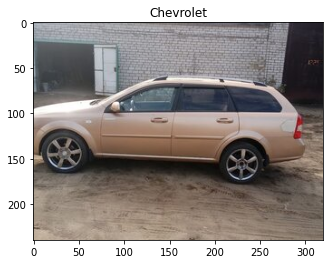

In [225]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1, 2, 0)
label = train_labels[0]
plt.imshow(img)
plt.title(dicts['producer'][int(label)])
plt.show()